In [3]:
# env requirement
# Python (3.7)
# pynrrd (0.4) - For loading MICCAI data in .nrrd format
# Tqdm - For displaying progress bars
# Torchvision (0.8)
# MONAI (0.7) - For domain specific models, losses, metrics, etc
# pytorch-lightning-1.5.3
# pytorch-1.10.0 
# torchtext-0.11.0



# Convert 3D Dataset (nrdd to npz)


In [5]:
from typing import Callable, Dict, List, Tuple, Union
import functools
from pathlib import Path
import nrrd
import numpy as np
import pandas as pd
import torch
from torchvision.utils import make_grid
from tqdm import tqdm


STRUCTURES: List[str] = [
    "BrainStem",
    "Chiasm",
    "Mandible",
    "OpticNerve_L",
    "OpticNerve_R",
    "Parotid_L",
    "Parotid_R",
    "Submandibular_L",
    "Submandibular_R",
]

    
LANDMARK_COLS: List[str] = [
    "id",
    "x",
    "y",
    "z",
    "ow",
    "ox",
    "oy",
    "oz",
    "vis",
    "sel",
    "lock",
    "label",
    "desc",
    "associatedNodeID",
]
    
class AttrDict(dict):
    """Subclasses dict and define getter-setter. This behaves as both dict and obj
    Taken from: https://github.com/facebookresearch/fair-sslime/blob/master/sslime/utils/collections.py
    """

    def __getattr__(self, key):
        return self[key]

    def __setattr__(self, key, value):
        if key in self.__dict__:
            self.__dict__[key] = value
        else:
            self[key] = value

    def __delattr__(self, key):
        if key in self:
            del self[key]

In [6]:
class Volume(object):
    def __init__(self, path: str = None, data: Union[np.ndarray, torch.Tensor] = None):
        if path is not None:
            self._path = path
            self._data, self._headers = load_nrrd_as_tensor(path)
        else:
            assert data is not None, "Either one of path or data (array) is required"
            self._path = self._headers = None
            self._data = self._check_data(data)
        self._is_data_modified = False

    def __repr__(self):
        return f"Volume(path={self.path})"

    @property
    def data(self) -> torch.Tensor:
        return self._data

    @data.setter
    def data(self, arr: Union[np.ndarray, torch.Tensor]) -> None:
        arr = self._check_data(arr)
        self._data = arr
        self._is_data_modified = True

    @property
    def path(self) -> Union[str, None]:
        return self._path

    @property
    def is_gray(self) -> bool:
        return True if self.data.shape[0] == 1 else False

    @property
    def spacing(self) -> Union[np.ndarray, None]:
        if self.headers is not None:
            # Reversed the array to align with channel first format
            # That is, spacing values in dimension: (z, ..., ...)
            return self.headers["space directions"].diagonal()[::-1]
        return None

    def _check_data(self, data: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """Only meant to be used internally."""
        assert len(data.shape) == 4, "Expected data to be of shape: (C, D, H, W)"
        assert data.shape[0] == 1, "Expected data to be in channel first format"
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data)

        return data

    def _crop_data(
        self, min_z: int, max_z: int, min_x: int, max_x: int, min_y: int, max_y: int
    ) -> None:
        """
        Only intended to be used internally. This function performs no checks,
        and updates the data according to the given crop information (and holds
        no reference to the 'old' data).
        All coordinates are expected to be integers.
        """
        self.data = self.data[:, min_z:max_z, min_x:max_x, min_y:max_y]

    def as_numpy(self, reverse_dims: bool = False) -> np.ndarray:
        arr = self.data.numpy()
        if reverse_dims:
            arr = np.transpose(arr, (2, 3, 1, 0))
        return arr

    def as_grid(
        self, nrow: int = 4, pad_value: int = 1, reverse_dims: bool = True, **kwargs
    ) -> np.ndarray:
        grid = make_grid(
            self.data.permute(1, 0, 2, 3), nrow=nrow, pad_value=pad_value, **kwargs
        )  # Shape: (C, nH, nW)

        if self.is_gray:
            grid = grid[[0]]  # All channels are the same according to the docs
        if reverse_dims:
            grid = grid.permute((1, 2, 0))  # Shape: (nH, nW, C)

        return grid.numpy()

In [7]:
class Patient(object):
    def __init__(self, patient_dir: str):
        self._patient_dir = patient_dir
        self.meta_data = self._store_meta_data()

        self._image = Volume(self.meta_data["image"])
        self._structures = self._load_structures()
        if self.meta_data["landmarks"] is not None:
            self._landmarks = pd.read_csv(
                self.meta_data["landmarks"], comment="#", names=LANDMARK_COLS
            )
        else:  # No landmarks for test data
            self._landmarks = None
        self._is_cropped = False

    def __repr__(self):
        return f"Patient(patient_dir={self.patient_dir})"

    @property
    def image(self) -> Volume:
        return self._image

    @property
    def structures(self) -> AttrDict:
        return self._structures

    @property
    def num_slides(self) -> int:
        return self.image.data.shape[1]

    @property
    def landmarks(self) -> Union[pd.DataFrame, None]:
        return self._landmarks

    @property
    def patient_dir(self) -> str:
        return self._patient_dir

    def _store_meta_data(self) -> Dict:
        meta_data = {
            "image": None,
            "structures": {s: None for s in STRUCTURES},
            "landmarks": None,
        }
        directory = Path(self.patient_dir)

        meta_data["image"] = (directory / "img.nrrd").as_posix()
        try:
            meta_data["landmarks"] = (list(directory.glob("*.fcsv"))[0]).as_posix()
        except IndexError:  # No landmarks for test data
            meta_data["landmarks"] = None

        for structure_path in (directory / "structures").iterdir():
            meta_data["structures"][structure_path.stem] = structure_path.as_posix()

        return meta_data

    def _load_structures(self) -> AttrDict:
        temp = AttrDict()
        for (structure, path) in self.meta_data["structures"].items():
            if path is not None:
                temp[structure] = Volume(path)
            else:
                temp[structure] = None

        return temp

    def crop_data(
        self,
        boundary_x: Tuple[int, int] = (120, 400),
        boundary_y: Tuple[int, int] = (55, 335),
        boundary_z: Tuple[float, float] = (0.32, 0.99),
    ):
        assert np.all(
            [isinstance(i, tuple) for i in (boundary_x, boundary_y, boundary_z)]
        ), "Cropping boundary is expected to be a tuple for each axis"

        min_x, max_x = boundary_x
        min_y, max_y = boundary_y
        min_z, max_z = boundary_z

        min_z = np.math.ceil(min_z * self.num_slides)
        max_z = np.math.ceil(max_z * self.num_slides)

        assert np.all(
            [isinstance(i, int) for i in (min_z, max_z, min_x, max_x, min_y, max_y)]
        ), (
            "'x' and 'y' coordinates are expected to be integers, and 'z' "
            "should be float between 0 and 1"
        )
        assert min_x < max_x, "Invalid x-axis boundaries"
        assert min_y < max_y, "Invalid y-axis boundaries"
        assert min_z < max_z, "Invalid z-axis boundaries"

        self.image._crop_data(min_z, max_z, min_x, max_x, min_y, max_y)
        for structure in STRUCTURES:
            if self.structures[structure] is not None:
                self.structures[structure]._crop_data(
                    min_z, max_z, min_x, max_x, min_y, max_y
                )

        self._is_cropped = True

    def combine_segmentation_masks(self, structure_list: list) -> np.ndarray:
        """
        This is used as a workaround for overlaying multiple segmentation masks
        (each corresponding to different region) over a slide. The "correct" way
        can be quite complicated, and is not worth the time for now.
        """
        assert len(structure_list) > 1, "A minimum of 2 structures are required"
        structure_arrays = []

        for structure in structure_list:
            assert structure in STRUCTURES, f"Invalid structure argument: {structure}"
            structure_volume = self.structures[structure]
            if structure_volume is not None:
                structure_arrays.append(structure_volume.as_numpy())

        combined = functools.reduce(np.logical_or, structure_arrays).astype(
            "uint8"
        )  # Shape: (C, D, H, W)
        return combined
    
    
class PatientCollection(object):
    def __init__(self, path: str):
        self._path = path
        self._patient_paths = {
            directory.name: directory.as_posix()
            for directory in Path(path).glob("0522c*")
        }
        assert (
            len(self._patient_paths) > 0
        ), "No patients found at the specified location: {path}"

    @property
    def patient_paths(self) -> Dict:
        return self._patient_paths

    def apply_function(
        self, func: Callable, disable_progress: bool = False, **kwargs
    ) -> Dict:
        """
        Applies the callable to each patient, and stores the result in a dictionary.
        Any extra keyword arguments will be passed to the callable.
        The callable should be of the following form:
        def func(patient: Patient, **kwargs):
            ...
        """
        iterator = tqdm(self.patient_paths.items(), disable=disable_progress)

        collected_results = {
            name: func(Patient(path), **kwargs) for (name, path) in iterator
        }

        return collected_results

In [8]:
def _patient_to_3d(
    patient: Patient, save_location: Path, crop: bool = True,
) -> None:
    """TODO
    """
    temp_patient = patient
    if crop:
        temp_patient.crop_data()
    patient_id = Path(temp_patient.patient_dir).stem
    vol = temp_patient.image.as_numpy()

    region_slides = []
    mask_indicator = np.ones(len(STRUCTURES))
    all_zeros = np.zeros_like(
        vol[0, :, :, :], dtype="uint8"
    )  # Dummy mask. Shape: (D, H, W)
    for i, structure in enumerate(STRUCTURES):
        region_volume = temp_patient.structures[structure]
        if region_volume is not None:
            region_slide = region_volume.as_numpy()[0, :, :, :]  # Shape: (D, H, W)
        else:
            region_slide = all_zeros
            mask_indicator[i] = 0
        region_slides.append(region_slide)

    region_slides = np.stack(
        region_slides
    )  # Shape: (9, D, H, W) -> 1 mask for each structure

    # Ignore the slide if there is no structure (BrainStem, etc) present
    # It's useless since there's nothing to train/validate on
    if region_slides.sum() > 0:
        filename = (save_location / f"{patient_id}.npz").as_posix()
        np.savez(
            filename, image=vol, masks=region_slides, mask_indicator=mask_indicator,
        )
        
def convert_to_3d(
    read_dir: str, save_dir: str, split: str = None, crop: bool = True,
) -> None:
    """TODO
    """
    read_location = Path(read_dir)
    save_location = Path(save_dir)
    if split is not None:
        read_location = read_location / split
        save_location = save_location / split

    save_location.mkdir(parents=True, exist_ok=True)
    read_location = read_location.as_posix()

    patient_collection = PatientCollection(read_location)
    _ = patient_collection.apply_function(
        _patient_to_3d, save_location=save_location, crop=crop,
    )

In [9]:
def load_nrrd_as_tensor(path: str) -> torch.Tensor:
    """
    Headers are returned without any changes. Should be kept in mind if used with the
    tensors, making sure that they both align.
    """
    img, headers = nrrd.read(path)
    if img.ndim == 3:  # grayscale, so adding channel=1
        img = img[:, :, :, np.newaxis]  # Shape: (H, W, D, C)
    tensor = torch.from_numpy(np.transpose(img, (3, 2, 0, 1)))  # Shape: (C, D, H, W)

    return (tensor, headers)

In [10]:
import os
from pathlib import Path
def is_cluster(cluster_type: str = "PRINCE") -> bool:
    """
    Will return True if executed on NYU's HPC Cluster Prince (by default).
    """
    env = os.environ.get("CLUSTER")
    return True if env == cluster_type else False


def _repository_root() -> Path:
    return (Path().resolve().parents[1]).absolute()
    # return (Path(__file__).resolve().parents[1]).absolute()


def _storage_root() -> Path:
    if not is_cluster():
        path = _repository_root() / 'My Drive' /"CT-image-segmentation" /"storage"
    else:
        beegfs_path = Path(os.environ.get("BEEGFS")).absolute()
        path = beegfs_path / "CT-image-segmentation" / "storage"

    return path.absolute()

# convert nrrd to npz
DEFAULT_DATA_STORAGE = '' #str = _storage_root().as_posix() 
read_dir = (Path(DEFAULT_DATA_STORAGE) / "miccai").as_posix()
save_dir = (Path(DEFAULT_DATA_STORAGE) / "miccai_3d_test").as_posix()
# convert_to_3d(read_dir,save_dir,"train")
# convert_to_3d(read_dir,save_dir,"test")
# convert_to_3d(read_dir,save_dir,"valid")

# Data Loader

In [11]:
DEFAULT_DATA_STORAGE = ''

In [12]:
import torch
from torchio.data.subject import Subject
from torchio.transforms.preprocessing.intensity.normalization_transform import NormalizationTransform, TypeMaskingMethod

_stacked_window_stats = {"mean": (0.107, 0.135, 0.085), "std": (0.271, 0.267, 0.152)}

class Normalization_DIY(NormalizationTransform):
    """Subtract mean and divide by standard deviation.

    Args:
        masking_method: See
            :class:`~torchio.transforms.preprocessing.intensity.NormalizationTransform`.
        **kwargs: See :class:`~torchio.transforms.Transform` for additional
            keyword arguments.
    """
    def __init__(
            self,
            masking_method: TypeMaskingMethod = None,
            **kwargs
            ):
        super().__init__(masking_method=masking_method, **kwargs)
        self.args_names = ('masking_method',)

    def apply_normalization(
            self,
            subject: Subject,
            image_name: str,
            mask: torch.Tensor,
            ) -> None:
        image = subject[image_name]
        standardized = self.znorm(
            image.data,
            mask,
        )
        if standardized is None:
            message = (
                'Standard deviation is 0 for masked values'
                f' in image "{image_name}" ({image.path})'
            )
            raise RuntimeError(message)
        image.set_data(standardized)

    @staticmethod
    def znorm(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        tensor = tensor.clone().float()
        min_ = -155
        max_ = 195
        tensor = (tensor - min_) / (max_ - min_ + 1e-8)

        return tensor

In [13]:
_stacked_window_stats = {"mean": (0, 0.135, 0.085), "std": (1, 0.267, 0.152)}

class Normalization_DIY_final(NormalizationTransform):
    """Subtract mean and divide by standard deviation.

    Args:
        masking_method: See
            :class:`~torchio.transforms.preprocessing.intensity.NormalizationTransform`.
        **kwargs: See :class:`~torchio.transforms.Transform` for additional
            keyword arguments.
    """
    def __init__(
            self,
            masking_method: TypeMaskingMethod = None,
            **kwargs
            ):
        super().__init__(masking_method=masking_method, **kwargs)
        self.args_names = ('masking_method',)

    def apply_normalization(
            self,
            subject: Subject,
            image_name: str,
            mask: torch.Tensor,
            ) -> None:
        image = subject[image_name]
        standardized = self.znorm(
            image.data,
            mask,
        )
        if standardized is None:
            message = (
                'Standard deviation is 0 for masked values'
                f' in image "{image_name}" ({image.path})'
            )
            raise RuntimeError(message)
        image.set_data(standardized)

    @staticmethod
    def znorm(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        tensor = tensor.clone().float()
        mean,std = _stacked_window_stats['mean'][1],_stacked_window_stats['std'][1]
        if std == 0:
            return None
        tensor -= mean
        denominator = np.reciprocal(std)
        tensor *= denominator
        return tensor

In [14]:
import torchio as tio
max_displacement = 2,2,2 
num_control_points = 5
SIZE = (96,128,224)
windowed_degree_0 = {
    "train": tio.Compose([
     tio.ToCanonical(),
     tio.CropOrPad(SIZE, mask_name='Segmentation'),
     tio.RescaleIntensity(out_min_max=(-155, 195)),
     Normalization_DIY(),
     tio.OneOf({
          tio.RandomElasticDeformation(max_displacement=max_displacement,\
                                       num_control_points=num_control_points):0.3,
          tio.RandomAffine(degrees=5,scales=0.1):0.7,
    }),
     Normalization_DIY_final(),
]),
    "test": tio.Compose([
     tio.ToCanonical(),
     tio.CropOrPad(SIZE, mask_name='Segmentation'),
     tio.RescaleIntensity(out_min_max=(-155, 195)),
     Normalization_DIY(),
     Normalization_DIY_final(),
]),

}

In [15]:
from pathlib import Path
from typing import Tuple
# use torchio not change masks  11.8
import numpy as np
import torch
from torch.utils.data import Dataset

def get_miccai_3d(split: str = "train", transform=None) -> Dataset:
    assert split in ["train", "valid", "test"], "Invalid data split passed"
    path = DEFAULT_DATA_STORAGE + f"/miccai_3d_test/{split}"

    path = Path(path).absolute()
    instance_paths = []
    for instance in path.iterdir():
            instance_paths.append(instance.as_posix())
            
      
    instance_paths.sort()  # To get same order on Windows and Linux (cluster)
    subjects_train = []
    for i in range(len(instance_paths)):
        instance = np.load(instance_paths[i])
        subject_train = tio.Subject(
          CT = tio.ScalarImage(tensor=instance['image']),
                    Segmentation = tio.LabelMap(tensor=instance['masks']),
        )
        subjects_train.append(subject_train)
    return tio.SubjectsDataset(subjects_train, transform = transform)


In [16]:
from typing import List, Optional, Union

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from multiprocessing import cpu_count
import torchio as tio


DEGREE = {0: windowed_degree_0}


class MiccaiDataModule3D(pl.LightningDataModule):
    def __init__(self, batch_size, transform_degree: int = None, **kwargs):
        super().__init__()
        self.batch_size = batch_size
        assert transform_degree in DEGREE.keys(), "Invalid transform degree passed"
        self.transform = DEGREE[transform_degree]

    def setup(self, stage: Optional[str]):
        if stage == "fit" or stage is None:
            self.train_dataset = get_miccai_3d(
                split="train", transform=self.transform["train"],
            )
            self.val_dataset = get_miccai_3d(
                split="valid", transform=self.transform["test"], #test
            )
            print("finish set up validation dataset")

        if stage == "test" or stage is None:
            self.test_dataset = get_miccai_3d(
                split="test", transform=self.transform["test"],
            )

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers= cpu_count())#cpu_count())
    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers= cpu_count()
        )

    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers= cpu_count()
        )

2022-05-26 11:39:21.684603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/share/apps/anaconda3/gpu/5.2.0/envs/tz904/lib:/gpfs/share/apps/cuda/9.0/extras/CUPTI/lib64:/gpfs/share/apps/cuda/9.0/lib64:/gpfs/share/apps/cuda/9.0/targets/x86_64-linux/lib
2022-05-26 11:39:21.684632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Model

In [17]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.utilities import rank_zero_only

class WandbLoggerPatch(WandbLogger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @rank_zero_only
    def log_hyperparams(self, params):
        params = self._convert_params(params)
        params = self._flatten_dict(params)
        params = self._sanitize_callable_params(params)
        params = self._sanitize_params(params)
        self.experiment.config.update(params, allow_val_change=True)

def _squash_predictions(preds):
    return torch.softmax(preds, dim=1).argmax(dim=1)  # Shape: (N, H, W)

In [18]:
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from monai.utils import LossReduction, MetricReduction, Weight
from typing import Callable, Optional, Union

class BaseLossWrapper(nn.Module):
    """TODO"""

    def __init__(self):
        super(BaseLossWrapper, self).__init__()

    @property
    def loss_fx(self):
        raise NotImplementedError

    def forward(self, input, target):
        input, target = self._process(input, target)
        return self.loss_fx(input, target)

    def _process(self, input, target):
        assert target.ndim == 3, "Expected target of shape: (N, H, W)"
        target = target.unsqueeze(dim=1)  # Shape: (N, 1, H, W)

        return (input, target)

class MultipleLossWrapper(nn.Module):
    def __init__(self, losses, exclude_missing=False):
        super(MultipleLossWrapper, self).__init__()
        self.exclude_missing = exclude_missing
        for name in losses:
            assert name in LOSSES.keys()

        reduction = "none" if self.exclude_missing else "mean"
        self.losses = nn.ModuleDict(
            {name: LOSSES[name](reduction=reduction) for name in losses}
        )

    def forward(self, input, target, mask_indicator=None, dist_maps=None):
        values = {}
#         if mask_indicator is not None:
#             mask_indicator = mask_indicator.type_as(input)

        for (name, fx) in self.losses.items():
            if name == "Boundary":
                assert (
                    dist_maps is not None
                ), "Distance maps are required for using boundary loss"
                loss = fx(input, dist_maps)
            else:
                loss = fx(input, target)  # Either scalar or (N, C)

            if self.exclude_missing and (
                name not in ["CrossEntropy", "WeightedCrossEntropy"]
            ):
                loss = apply_missing_mask(name, loss, mask_indicator)

            values[name] = loss

        return values

class GeneralizedDiceLoss(_Loss):
    """
    Compute the generalised Dice loss defined in:
        Sudre, C. et. al. (2017) Generalised Dice overlap as a deep learning
        loss function for highly unbalanced segmentations. DLMIA 2017.
    Adapted from:
        https://github.com/NifTK/NiftyNet/blob/v0.6.0/niftynet/layer/loss_segmentation.py#L279
    """

    def __init__(
        self,
        include_background: bool = True,
        to_onehot_y: bool = False,
        sigmoid: bool = False,
        softmax: bool = False,
        other_act: Optional[Callable] = None,
        w_type: Union[Weight, str] = Weight.SQUARE,
        reduction: Union[LossReduction, str] = LossReduction.MEAN,
        smooth_nr: float = 1e-5,
        smooth_dr: float = 1e-5,
        batch: bool = False,
    ) -> None:
        """
        Args:
            include_background: If False channel index 0 (background category) is excluded from the calculation.
            to_onehot_y: whether to convert `y` into the one-hot format. Defaults to False.
            sigmoid: If True, apply a sigmoid function to the prediction.
            softmax: If True, apply a softmax function to the prediction.
            other_act: if don't want to use `sigmoid` or `softmax`, use other callable function to execute
                other activation layers, Defaults to ``None``. for example:
                `other_act = torch.tanh`.
            squared_pred: use squared versions of targets and predictions in the denominator or not.
            w_type: {``"square"``, ``"simple"``, ``"uniform"``}
                Type of function to transform ground truth volume to a weight factor. Defaults to ``"square"``.
            reduction: {``"none"``, ``"mean"``, ``"sum"``}
                Specifies the reduction to apply to the output. Defaults to ``"mean"``.
                - ``"none"``: no reduction will be applied.
                - ``"mean"``: the sum of the output will be divided by the number of elements in the output.
                - ``"sum"``: the output will be summed.
            smooth_nr: a small constant added to the numerator to avoid zero.
            smooth_dr: a small constant added to the denominator to avoid nan.
            batch: whether to sum the intersection and union areas over the batch dimension before the dividing.
                Defaults to False, intersection over union is computed from each item in the batch.
        Raises:
            TypeError: When ``other_act`` is not an ``Optional[Callable]``.
            ValueError: When more than 1 of [``sigmoid=True``, ``softmax=True``, ``other_act is not None``].
                Incompatible values.
        """
        super().__init__(reduction=LossReduction(reduction).value)
        if other_act is not None and not callable(other_act):
            raise TypeError(
                f"other_act must be None or callable but is {type(other_act).__name__}."
            )
        if int(sigmoid) + int(softmax) + int(other_act is not None) > 1:
            raise ValueError(
                "Incompatible values: more than 1 of [sigmoid=True, softmax=True, other_act is not None]."
            )
        self.include_background = include_background
        self.to_onehot_y = to_onehot_y
        self.sigmoid = sigmoid
        self.softmax = softmax
        self.other_act = other_act

        w_type = Weight(w_type)
        self.w_func: Callable = torch.ones_like
        if w_type == Weight.SIMPLE:
            self.w_func = torch.reciprocal
        elif w_type == Weight.SQUARE:
            self.w_func = lambda x: torch.reciprocal(x * x)

        self.smooth_nr = float(smooth_nr)
        self.smooth_dr = float(smooth_dr)
        self.batch = batch

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            input: the shape should be BNH[WD].
            target: the shape should be BNH[WD].
        Raises:
            ValueError: When ``self.reduction`` is not one of ["mean", "sum", "none"].
        """
        if self.sigmoid:
            input = torch.sigmoid(input)
        n_pred_ch = input.shape[1]
        if self.softmax:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `softmax=True` ignored.")
            else:
                input = torch.softmax(input, 1)

        if self.other_act is not None:
            input = self.other_act(input)

        if self.to_onehot_y:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")
            else:
                target = one_hot(target, num_classes=n_pred_ch)

        if not self.include_background:
            if n_pred_ch == 1:
                warnings.warn(
                    "single channel prediction, `include_background=False` ignored."
                )
            else:
                # if skipping background, removing first channel
                target = target[:, 1:]
                input = input[:, 1:]

        assert (
            target.shape == input.shape
        ), f"ground truth has differing shape ({target.shape}) from input ({input.shape})"

        # reducing only spatial dimensions (not batch nor channels)
        reduce_axis = list(range(2, len(input.shape)))
        if self.batch:
            reduce_axis = [0] + reduce_axis
        intersection = torch.sum(target * input, reduce_axis)

        ground_o = torch.sum(target, reduce_axis)
        pred_o = torch.sum(input, reduce_axis)

        denominator = ground_o + pred_o

        w = self.w_func(ground_o.float())
        for b in w:
            infs = torch.isinf(b)
            b[infs] = 0.0
            b[infs] = torch.max(b)

        f: torch.Tensor = 1.0 - (2.0 * (intersection * w) + self.smooth_nr) / (
            (denominator * w) + self.smooth_dr
        )

        if self.reduction == LossReduction.MEAN.value:
            f = torch.mean(f)  # the batch and channel average
        elif self.reduction == LossReduction.SUM.value:
            f = torch.sum(f)  # sum over the batch and channel dims
        elif self.reduction == LossReduction.NONE.value:
            pass  # returns [N, n_classes] losses
        else:
            raise ValueError(
                f'Unsupported reduction: {self.reduction}, available options are ["mean", "sum", "none"].'
            )

        return f

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-sw070c0e because the default path (/gpfs/home/tz904/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [19]:

from monai.losses.dice import DiceLoss
from monai.losses.focal_loss import FocalLoss
from monai.transforms import AsDiscrete
import torch
import torch.nn.functional as F

WEIGHT = {
    "Background": 1e-10,
    "BrainStem": 0.007,
    "Chiasm": 0.3296,
    "Mandible": 0.0046,
    "OpticNerve_L": 0.2619,
    "OpticNerve_R": 0.3035,
    "Parotid_L": 0.0068,
    "Parotid_R": 0.0065,
    "Submandibular_L": 0.0374,
    "Submandibular_R": 0.0426,
}  # Inverse pixel-frequency (Background is given no weight)


class BaseLossWrapper3D(BaseLossWrapper):
    """TODO"""

    def __init__(self):
        super(BaseLossWrapper3D, self).__init__()

    def _process(self, input, target):
        # assert target.ndim == 3, "Expected target of shape: (N, H, W)"
        target = target.unsqueeze(dim=1)  # Shape: (N, 1, H, W)

        return (input, target)


class CrossEntropyWrapper3D(BaseLossWrapper3D):
    """TODO"""

    def __init__(self, **kwargs):
        super(CrossEntropyWrapper3D, self).__init__()

    @property
    def loss_fx(self):
        return F.cross_entropy

    def _process(self, input, target):
        return (input, target)


class WeightedCrossEntropyWrapper3D(CrossEntropyWrapper3D):
    """TODO"""

    def __init__(self, **kwargs):
        super(WeightedCrossEntropyWrapper3D, self).__init__()
        self.weight = torch.as_tensor(list(WEIGHT.values()))

    def forward(self, input, target):
        input, target = self._process(input, target)
        return self.loss_fx(input, target, weight=self.weight.type_as(input))


class DiceLossWrapper3D(BaseLossWrapper3D):
    """TODO"""

    def __init__(self, reduction="mean"):
        super(DiceLossWrapper3D, self).__init__()
        self.reduction = reduction
        print("reduction inside dicelosswrapper3d",reduction)

    @property
    def loss_fx(self):
        return DiceLoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            reduction=self.reduction,
        )


class GeneralizedDiceLossWrapper3D(BaseLossWrapper3D):
    """TODO"""

    def __init__(self, reduction="mean"): 
        super(GeneralizedDiceLossWrapper3D, self).__init__()
        self.reduction = reduction

    @property
    def loss_fx(self):
        return GeneralizedDiceLoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            reduction=self.reduction,
        )


class FocalLossWrapper3D(BaseLossWrapper3D):
    """TODO"""

    def __init__(self, reduction="mean"):
        super(FocalLossWrapper3D, self).__init__()
        self.reduction = reduction
        self.n_classes = len(STRUCTURES) + 1  # Additional background

    @property
    def loss_fx(self):
        return FocalLoss(reduction=self.reduction)

    def _process(self, input, target):
        target = target.unsqueeze(dim=0)  #1 # Shape: (N, 1, H, W) 
        
        expand = AsDiscrete(to_onehot=True, n_classes=self.n_classes)
        target = expand(target)
        target = target.reshape((target.shape[1],target.shape[0],target.shape[2],target.shape[3],target.shape[4]))
        return (input,target)


LOSSES = {
    "CrossEntropy": CrossEntropyWrapper3D,
    "WeightedCrossEntropy": WeightedCrossEntropyWrapper3D,
    "Focal": FocalLossWrapper3D,
    "Dice": DiceLossWrapper3D,
    "GeneralizedDice": GeneralizedDiceLossWrapper3D,
}



In [20]:
class MultipleLossWrapper3D(MultipleLossWrapper):
    def __init__(self, losses, exclude_missing=False):
        super(MultipleLossWrapper3D, self).__init__(losses, exclude_missing)

In [21]:
from monai.transforms import AsDiscrete
from typing import Callable, Optional, Union
import warnings
from functools import partial
from monai.networks import one_hot
from monai.utils import LossReduction, MetricReduction, Weight
import torch
from torch.nn.modules.loss import _Loss
from monai.metrics import HausdorffDistanceMetric,compute_hausdorff_distance

def compute_meandice(
    y_pred: torch.Tensor, y: torch.Tensor, include_background: bool = True,
) -> torch.Tensor:
    """Computes Dice score metric from full size Tensor and collects average.
    Args:
        y_pred: input data to compute, typical segmentation model output.
            It must be one-hot format and first dim is batch, example shape: [16, 3, 32, 32]. The values
            should be binarized.
        y: ground truth to compute mean dice metric. It must be one-hot format and first dim is batch.
            The values should be binarized.
        include_background: whether to skip Dice computation on the first channel of
            the predicted output. Defaults to True.
    Returns:
        Dice scores per batch and per class, (shape [batch_size, n_classes]).
    Raises:
        ValueError: when `y_pred` and `y` have different shapes.
    """

    if not include_background:
        y_pred, y = ignore_background(y_pred=y_pred, y=y,)

    y = y.float()
    y_pred = y_pred.float()

    if y.shape != y_pred.shape:
        raise ValueError("y_pred and y should have same shapes.")

    # reducing only spatial dimensions (not batch nor channels)
    n_len = len(y_pred.shape)
    reduce_axis = list(range(2, n_len))
    intersection = torch.sum(y * y_pred, dim=reduce_axis)

    y_o = torch.sum(y, reduce_axis)
    y_pred_o = torch.sum(y_pred, dim=reduce_axis)
    denominator = y_o + y_pred_o

    f = torch.where(
        y_o > 0,
        (2.0 * intersection) / denominator,
        torch.tensor(float("nan"), device=y_o.device),
    )
    return f  # returns array of Dice with shape: [batch, n_classes]


def do_metric_reduction(
    f: torch.Tensor, reduction: Union[MetricReduction, str] = MetricReduction.MEAN,
):
    """
    This function is to do the metric reduction for calculated metrics of each example's each class.
    Args:
        f: a tensor that contains the calculated metric scores per batch and
            per class. The first two dims should be batch and class.
        reduction: {``"none"``, ``"mean"``, ``"sum"``, ``"mean_batch"``, ``"sum_batch"``,
        ``"mean_channel"``, ``"sum_channel"``}
        Define the mode to reduce computation result of 1 batch data. Defaults to ``"mean"``.
    Raises:
        ValueError: When ``reduction`` is not one of
            ["mean", "sum", "mean_batch", "sum_batch", "mean_channel", "sum_channel" "none"].
    """

    # some elements might be Nan (if ground truth y was missing (zeros))
    # we need to account for it
    nans = torch.isnan(f)
    not_nans = (~nans).float()
    f[nans] = 0

    t_zero = torch.zeros(1, device=f.device, dtype=torch.float)
    reduction = MetricReduction(reduction)

    if reduction == MetricReduction.MEAN:
        # 2 steps, first, mean by channel (accounting for nans), then by batch
        not_nans = not_nans.sum(dim=1)
        f = torch.where(
            not_nans > 0, f.sum(dim=1) / not_nans, t_zero
        )  # channel average

        not_nans = (not_nans > 0).float().sum(dim=0)
        f = torch.where(not_nans > 0, f.sum(dim=0) / not_nans, t_zero)  # batch average

    elif reduction == MetricReduction.SUM:
        not_nans = not_nans.sum(dim=[0, 1])
        f = torch.sum(f, dim=[0, 1])  # sum over the batch and channel dims
    elif reduction == MetricReduction.MEAN_BATCH:
        not_nans = not_nans.sum(dim=0)
        f = torch.where(not_nans > 0, f.sum(dim=0) / not_nans, t_zero)  # batch average
    elif reduction == MetricReduction.SUM_BATCH:
        not_nans = not_nans.sum(dim=0)
        f = f.sum(dim=0)  # the batch sum
    elif reduction == MetricReduction.MEAN_CHANNEL:
        not_nans = not_nans.sum(dim=1)
        f = torch.where(
            not_nans > 0, f.sum(dim=1) / not_nans, t_zero
        )  # channel average
    elif reduction == MetricReduction.SUM_CHANNEL:
        not_nans = not_nans.sum(dim=1)
        f = f.sum(dim=1)  # the channel sum
    elif reduction == MetricReduction.NONE:
        pass
    else:
        raise ValueError(
            f"Unsupported reduction: {reduction}, available options are "
            '["mean", "sum", "mean_batch", "sum_batch", "mean_channel", "sum_channel" "none"].'
        )
    return f, not_nans

class DiceMetricWrapper(object):
    """TODO"""

    def __init__(self):
        self.metric_fx = partial(compute_meandice, include_background=False)
        self.n_classes = len(STRUCTURES) + 1  # Additional background

    def __call__(self, input, target):
        input, target = self._process(input, target)
        input = input.reshape((input.shape[1],input.shape[0],input.shape[2],input.shape[3],input.shape[4]))
        target = target.reshape((target.shape[1],target.shape[0],target.shape[2],target.shape[3],target.shape[4]))

        score = self.metric_fx(input, target)  # Shape: (N, C)
        
        dice_per_class = do_metric_reduction(score, "mean_batch")[0]
        dice_mean = dice_per_class.mean()
        return dice_mean, dice_per_class

    def _process(self, input, target):
        assert input.ndim == 3, "Expected input of shape: (N, H, W)"
        assert target.ndim == 3, "Expected target of shape: (N, H, W)"

        input = input.unsqueeze(dim=0)  # Shape: (N, 1, H, W) #1
        target = target.unsqueeze(dim=0)  # Shape: (N, 1, H, W) #1

        expand = AsDiscrete(to_onehot=True, n_classes=self.n_classes)
        return expand(input), expand(target)  # Shape: (N, C, H, W) - binarized

class DiceMetricWrapper3D(DiceMetricWrapper):
    """TODO"""

    def __init__(self):
        super(DiceMetricWrapper3D, self).__init__()

    def _process(self, input, target):
        # remove for now, consider making maybe 3D loss function
        # assert input.ndim == 3, "Expected input of shape: (N, H, W)"
        # assert target.ndim == 3, "Expected target of shape: (N, H, W)"

        input = input.unsqueeze(dim=0)  # Shape: (N, 1, H, W)
        target = target.unsqueeze(dim=0)  # Shape: (N, 1, H, W)

        expand = AsDiscrete(to_onehot=True, n_classes=self.n_classes)
        return expand(input), expand(target)  # Shape: (N, C, H, W) - binarized
    

from monai.metrics.utils import do_metric_reduction as do_metric_reduction_hdm

class HausdorffDistanceMetricWrapper(object):
    """TODO"""

    def __init__(self):
        self.metric_fx = partial(compute_hausdorff_distance, include_background=False)
        self.n_classes = len(STRUCTURES) + 1  # Additional background

    def __call__(self, input, target):
        input, target = self._process(input, target)
        input = input.reshape((input.shape[1],input.shape[0],input.shape[2],input.shape[3],input.shape[4]))
        target = target.reshape((target.shape[1],target.shape[0],target.shape[2],target.shape[3],target.shape[4]))

        score = self.metric_fx(input, target,percentile=95)  # Shape: (N, C)
        
#         dice_per_class = do_metric_reduction(score, "mean_batch")[0]
#         dice_mean = dice_per_class.mean()

        dice_per_class = do_metric_reduction_hdm(score,'mean_batch')[0]
        dice_mean = dice_per_class.mean()
        return dice_mean, dice_per_class

    def _process(self, input, target):
        assert input.ndim == 3, "Expected input of shape: (N, H, W)"
        assert target.ndim == 3, "Expected target of shape: (N, H, W)"

        input = input.unsqueeze(dim=0)  # Shape: (N, 1, H, W) #1
        target = target.unsqueeze(dim=0)  # Shape: (N, 1, H, W) #1

        expand = AsDiscrete(to_onehot=True, n_classes=self.n_classes)
        return expand(input), expand(target)  # Shape: (N, C, H, W) - binarized
    
    
class HausdorffDistanceMetricWrapper3D(HausdorffDistanceMetricWrapper):
    """TODO"""

    def __init__(self):
        super(HausdorffDistanceMetricWrapper3D, self).__init__()

    def _process(self, input, target):
        # remove for now, consider making maybe 3D loss function
        # assert input.ndim == 3, "Expected input of shape: (N, H, W)"
        # assert target.ndim == 3, "Expected target of shape: (N, H, W)"

        input = input.unsqueeze(dim=0)  # Shape: (N, 1, H, W)
        target = target.unsqueeze(dim=0)  # Shape: (N, 1, H, W)

        expand = AsDiscrete(to_onehot=True, n_classes=self.n_classes)
        return expand(input), expand(target)  # Shape: (N, C, H, W) - binarized

In [38]:
from monai.networks.nets import UNet,UNETR
from argparse import ArgumentParser
from typing import List
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, Trainer
import torch
import torch.optim as optim

to_do_lst = [[],[]]

def _squash_masks_3D(masks, n_classes, device):
    _temp = torch.arange(1, n_classes, device=device)
    masks = (masks * _temp[None, :, None, None, None]).max(dim=1).values
    return masks

class BaseUNet3D(pl.LightningModule):
    def __init__(
        self,
        filters: List = [16, 32, 64, 128, 256], #[16, 32, 64, 128, 256]
        use_res_units: bool = False,
        downsample: bool = False,
        lr: float = 1e-3,
        loss_fx: list = ["CrossEntropy"],
        exclude_missing: bool = False,
        model: str ='3dunet',
        **kwargs,
    ) -> None:
        super().__init__()

        assert isinstance(loss_fx, list), "This module expects a list of loss functions"
        loss_fx.sort()  # To have consistent order of loss functions
        self.model = model
        self.save_hyperparameters(
            "batch_size",
            "transform_degree",
            "filters",
            "use_res_units",
            "downsample",
            "lr",
            "loss_fx",
            "exclude_missing",
            "model",
        )

        self.unet = self._construct_model()
        self.loss_func = MultipleLossWrapper3D(
            losses=loss_fx, exclude_missing=exclude_missing
        )
        self.dice_score = DiceMetricWrapper3D()
        self.hausdorff_distance  = HausdorffDistanceMetricWrapper3D()
        self.weight_focal = 0.1
        self.weight_weightedcrossentropy = 1

    @property
    def _n_classes(self):
        return len(STRUCTURES) + 1  # Additional background

    def _construct_model(self):
        # in_channels = (
        #    1 if self.hparams.downsample else 3
        # )  # assuming transform_degree in [1, 2, 3, 4]
        strides = [2, 2, 2, 2]  # Default for 5-layer UNet
        in_channels = 1  
        if self.model == '3dunet':#[3dunet,transuneter]
            return UNet(
            dimensions=3,
            in_channels=in_channels,
            out_channels=self._n_classes,
            channels=self.hparams.filters,
            strides=strides,
            num_res_units=3,
            )
        elif  self.model == 'transuneter':
            return UNETR(in_channels=in_channels, 
                    out_channels=self._n_classes, 
                    img_size=SIZE, #(96,128,224)
                    feature_size= 32, 
                    norm_name='batch')


    def forward(self, x):
        x = self.unet(x)
        return x

    def training_step(self, batch, batch_idx):
        # print("start training")
        _, _, _, _, loss = self._shared_step(batch, prefix = 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, prefix='val')
    
    def test_step(self, batch, batch_idx):
        self._shared_step(batch, prefix='test')

    def _shared_step(self, batch, prefix: str):
        # Image : Bx1xHxWxD (4x1x96x128x224 usually) #Masks : Bx9xHxWxD (1x9x96x128x224  usually)
        (images, masks) = batch['CT'][tio.DATA],batch['Segmentation'][tio.DATA]
        mask_indicator = np.ones(len(STRUCTURES))
 
        masks = _squash_masks_3D(
            masks, self._n_classes, self.device
        )  # Masks: BxHxWxD (4x96x128x224  usually) has number in [0-9] indicating one of 10 classes

        prediction = self.forward(
            images
        )  # Prediction: Bx10xHxWxD (4x10x96x128x224 usually)
        masks = masks.type(torch.cuda.LongTensor)
        loss_dict = self.loss_func(
            input=prediction, target=masks, mask_indicator=mask_indicator
        )
        total_loss = 0
        for name, loss_value in loss_dict.items():
            if name == "GeneralizedDice":
                total_loss += loss_value
            elif name =="Focal":
                total_loss += self.weight_focal * loss_value
            elif name == "WeightedCrossEntropy":
                total_loss += self.weight_weightedcrossentropy * loss_value
            self.log(
                f"{name} Loss ({prefix})", loss_value, on_step=False, on_epoch=True,
            )

        self._log_dice_scores(prediction, masks, mask_indicator, prefix)
        return images, masks, mask_indicator, prediction, total_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)

    def _log_dice_scores(self, prediction, masks, mask_indicator, prefix):
        pred = prediction.clone()
        self.eval()
        with torch.no_grad():
            if self.hparams.exclude_missing:
#             No indicator for background
              pred[:, 1:, :, :] = pred[:, 1:, :, :] * mask_indicator[:, :, None, None]
            
            
            pred = _squash_predictions(pred)  # Shape: (N, H, W)
            hausdorff_distance_mean, hausdorff_distance_per_class = self.hausdorff_distance(pred,masks)
            dice_mean, dice_per_class = self.dice_score(pred, masks)
            for structure, score in zip(STRUCTURES, dice_per_class):
                self.log(
                    f"{structure} Dice ({prefix})", score, on_step=False, on_epoch=True,
                )
            self.log(
                f"Mean Dice Score ({prefix})", dice_mean, on_step=False, on_epoch=True,
            )
            
            for structure, score in zip(STRUCTURES, hausdorff_distance_per_class):
                self.log(
                    f"{structure} Hausdorff distance ({prefix})", score, on_step=False, on_epoch=True,
                )
            self.log(
                f"Mean Hausdorff distance ({prefix})", hausdorff_distance_mean, on_step=False, on_epoch=True,
            )

            
        if prefix == "val":
          if dice_mean > 0.2:
              self.weight_weightedcrossentropy = 0.1 
              self.weight_focal = 0.5 
          elif dice_mean > 0.4:
              self.weight_weightedcrossentropy = 0.01 
              self.weight_focal = 1
              self.hparams.lr = self.hparams.lr/10
          elif dice_mean > 0.5:
              self.hparams.lr = self.hparams.lr/2
        self.train()

    @staticmethod
    def add_model_specific_args(parent_parser):
        """The parameters specific to the model/data processing."""
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument(
            "--batch_size", type=int, default=1, help="Batch size",
        )
        parser.add_argument(
            "--transform_degree",
            type=int,
            default=0,
            help="The degree of transforms/data augmentation to be applied",
        )
        parser.add_argument(
            "--filters",
            nargs=5,
            type=int,
            default=[64, 128, 256, 512, 1024],
            help="A sqeuence of number of filters for the downsampling path in UNet",
        )
        parser.add_argument(
            "--use_res_units",
            action="store_true",
            default=False,
            help="For using residual units in UNet",
        )
        parser.add_argument(
            "--downsample",
            action="store_true",
            default=False,
            help="For using a 1x1 convolution to downsample the input before UNet",
        )
        parser.add_argument(
            "--lr", type=float, default=1e-3, help="Learning rate",
        )
        parser.add_argument(
            "--loss_fx",
            nargs="+",
            type=str,
            default="CrossEntropy",
            help="Loss function",
        )
        parser.add_argument(
            "--exclude_missing",
            action="store_true",
            default=False,
            help="Exclude missing annotations from loss computation as described in AnatomyNet",
        )
        return parser

In [39]:
def ignore_background(
    y_pred: torch.Tensor, y: torch.Tensor,
):
    """
    This function is used to remove background (the first channel) for `y_pred` and `y`.
    Args:
        y_pred: predictions. As for classification tasks,
            `y_pred` should has the shape [BN] where N is larger than 1. As for segmentation tasks,
            the shape should be [BNHW] or [BNHWD].
        y: ground truth, the first dim is batch.
    """
    y = y[:, 1:] if y.shape[1] > 1 else y
    y_pred = y_pred[:, 1:] if y_pred.shape[1] > 1 else y_pred
    return y_pred, y

In [40]:
from wandb import Image
from pytorch_lightning.callbacks import Callback

class ExamplesLoggingCallback(Callback):
    """Callback to upload sample predictions to W&B."""

    def __init__(self, log_every_n_epochs=25, seed=None) -> None:
        super().__init__()
        self.log_every_n_epochs = log_every_n_epochs
        self.rng = np.random.default_rng(seed=seed)

    def on_fit_start(self, trainer, pl_module):
        self.sample_indices = self.rng.choice(
            np.arange(pl_module.hparams.batch_size, dtype=int),
            size=min(pl_module.hparams.batch_size, 50),
            replace=False,
        )
        self.num_val_batches = len(trainer.datamodule.val_dataloader())

    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx
    ):
        if (trainer.current_epoch % self.log_every_n_epochs == 0) and (
            (batch_idx + 1) != self.num_val_batches
        ):
            with torch.no_grad():
                sample_images, sample_masks, sample_preds = self._make_predictions(
                    batch, pl_module
                )
                self._log_images(
                    sample_images,
                    sample_masks,
                    sample_preds,
                    pl_module,
                    "val_sample_predictions",
                )

    def on_test_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx
    ):
        num_test_batches = len(trainer.datamodule.test_dataloader())
        if (batch_idx + 1) != num_test_batches:
            with torch.no_grad():
                sample_images, sample_masks, sample_preds = self._make_predictions(
                    batch, pl_module
                )
                self._log_images(
                    sample_images,
                    sample_masks,
                    sample_preds,
                    pl_module,
                    "test_sample_predictions",
                )

    def _make_predictions(self, batch, pl_module):
        images, masks, mask_indicator, *others = batch
        images = images.to(pl_module.device)
        masks = masks.to(pl_module.device)
        mask_indicator = mask_indicator.to(pl_module.device).type_as(images)

        masks = _squash_masks(masks, pl_module._n_classes, pl_module.device)

        sample_images = images[self.sample_indices]
        sample_masks = masks[self.sample_indices]
        sample_mask_indicator = mask_indicator[self.sample_indices]
        sample_preds = pl_module.forward(sample_images)
        if pl_module.hparams.exclude_missing:
            # No indicator for background
            sample_preds[:, 1:, :, :] = (
                sample_preds[:, 1:, :, :] * sample_mask_indicator[:, :, None, None]
            )

        return sample_images, sample_masks, sample_preds

    def _log_images(self, images, batch_mask, batch_pred, pl_module, title=None):
        batch_pred = _squash_predictions(batch_pred)  # Shape: (N, H, W)

        class_labels = dict(zip(range(1, pl_module._n_classes), miccai.STRUCTURES))
        class_labels[0] = "Void"

        vis_list = []
        for i, sample in enumerate(images):
            wandb_obj = Image(
                sample.permute(1, 2, 0).detach().cpu().numpy(),
                masks={
                    "predictions": {
                        "mask_data": batch_pred[i].detach().cpu().numpy(),
                        "class_labels": class_labels,
                    },
                    "ground_truth": {
                        "mask_data": batch_mask[i].detach().cpu().numpy(),
                        "class_labels": class_labels,
                    },
                },
            )
            vis_list.append(wandb_obj)

        pl_module.logger.experiment.log(
            {f"{title}": vis_list}, step=pl_module.trainer.global_step
        )

In [41]:
def _squash_masks(masks, n_classes, device):
    _temp = torch.arange(1, n_classes, device=device)
    masks = (masks * _temp[None, :, None, None]).max(dim=1).values
    return masks

# Training

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor,ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import seed_everything
SEED = 12342
seed_everything(SEED)
dict_args = {
    "experiment_name":"UNet 3D",
    'model':'3dunet', #[3dunet,transuneter]
    "gpus":[0],
    "transform_degree":0,
    "use_wandb": True,
    "batch_size":1, 
    "filters":[64, 128, 256, 512, 1024],
    "use_res_units":True,
    "downsample":False,
    "lr": 1e-3, 
    "loss_fx":["GeneralizedDice","Focal","WeightedCrossEntropy"],
    "exclude_missing": False, 
    "default_root_dir":DEFAULT_DATA_STORAGE,
    "logger":WandbLoggerPatch(
            name="test_3d",
            save_dir=DEFAULT_DATA_STORAGE,
            project="ct-image-segmentation",
        ),
    "log_every_n_steps":20
}

dict_args_trainer = {
    "gpus":[0],
    "callbacks": [LearningRateMonitor(logging_interval="epoch"),\
                  EarlyStopping(monitor="Mean Dice Score (val)", patience=50, mode="max"),\
                  ModelCheckpoint(monitor="Mean Dice Score (val)", mode="max")],

    "log_every_n_steps":20
}

# Data
miccai_3d = MiccaiDataModule3D(**dict_args)

# load empty model
model = BaseUNet3D(**dict_args)

# for transfer model (fix the first half layers)
# cnt = 0
# fix = 37
# for param in model.parameters():
#     cnt += 1
#     param.requires_grad = False
#     if cnt > fix:
#         break

# Trainer
trainer = Trainer(**dict_args_trainer)
trainer.fit(model=model, datamodule=miccai_3d)
trainer.test(model=model, datamodule=miccai_3d)

# Data Visualization

In [74]:
image = miccai_3d.test_dataset.__getitem__(2)['CT'][tio.DATA].unsqueeze(0)
masks = miccai_3d.test_dataset.__getitem__(2)['Segmentation'][tio.DATA].data.unsqueeze(0)

torch.Size([1, 1, 96, 128, 224])


No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


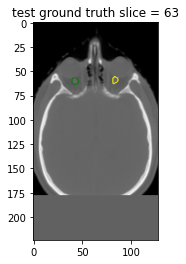

In [77]:
print(image.shape)
prediction = model(image)
import matplotlib.pyplot as plt
axslice= 63
img1=plt.imshow(np.rot90(image[0,0,axslice,:,:],k=3),cmap='gray')
img2=plt.contour(np.rot90(masks[0,0,axslice,:,:],k=3),colors='red',linewidths=0.5,linestyles='dotted')
img3=plt.contour(np.rot90(masks[0,1,axslice,:,:],k=3),colors='blue',linewidths=0.5,linestyles='dotted')
img4=plt.contour(np.rot90(masks[0,2,axslice,:,:],k=3),colors='orange',linewidths=0.5,linestyles='dotted')
img5=plt.contour(np.rot90(masks[0,3,axslice,:,:],k=3),colors='green',linewidths=0.5,linestyles='dotted')
img6=plt.contour(np.rot90(masks[0,4,axslice,:,:],k=3),colors='yellow',linewidths=0.5,linestyles='dotted')
img7=plt.contour(np.rot90(masks[0,5,axslice,:,:],k=3),colors='magenta',linewidths=0.5,linestyles='dotted')
img8=plt.contour(np.rot90(masks[0,6,axslice,:,:],k=3),colors='brown',linewidths=0.5,linestyles='dotted')
img9=plt.contour(np.rot90(masks[0,7,axslice,:,:],k=3),colors='purple',linewidths=0.5,linestyles='dotted')
img10=plt.contour(np.rot90(masks[0,8,axslice,:,:],k=3),colors='pink',linewidths=0.5,linestyles='dotted')
plt.title('test ground truth slice = {}'.format(axslice))
plt.show()

No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


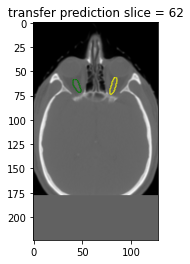

In [68]:
pred = _squash_predictions(prediction).detach().numpy()
img1=plt.imshow(np.rot90(image[0,0,axslice,:,:],k=3),cmap='gray')
img2=plt.contour(np.rot90(np.where(pred==1, 1,0)[0,axslice,:,:],k=3),colors='red',linewidths=0.5,linestyles='dotted')
img3=plt.contour(np.rot90(np.where(pred==2, 1,0)[0,axslice,:,:],k=3),colors='blue',linewidths=0.5,linestyles='dotted')
img4=plt.contour(np.rot90(np.where(pred==3, 1,0)[0,axslice,:,:],k=3),colors='orange',linewidths=0.5,linestyles='dotted')
img5=plt.contour(np.rot90(np.where(pred==4, 1,0)[0,axslice,:,:],k=3),colors='green',linewidths=0.5,linestyles='dotted')
img6=plt.contour(np.rot90(np.where(pred==5, 1,0)[0,axslice,:,:],k=3),colors='yellow',linewidths=0.5,linestyles='dotted')
img7=plt.contour(np.rot90(np.where(pred==6, 1,0)[0,axslice,:,:],k=3),colors='magenta',linewidths=0.5,linestyles='dotted')
img8=plt.contour(np.rot90(np.where(pred==7, 1,0)[0,axslice,:,:],k=3),colors='brown',linewidths=0.5,linestyles='dotted')
img9=plt.contour(np.rot90(np.where(pred==8, 1,0)[0,axslice,:,:],k=3),colors='purple',linewidths=0.5,linestyles='dotted')
img10=plt.contour(np.rot90(np.where(pred==9, 1,0)[0,axslice,:,:],k=3),colors='pink',linewidths=0.5,linestyles='dotted')
plt.title('transfer prediction slice = {}'.format(axslice))
plt.show()